In [45]:
import warnings

warnings.filterwarnings("ignore")
import numpy as np
from matplotlib import pyplot as plt

from qiskit_nature.drivers import Molecule
from qiskit_nature.drivers.second_quantization import PySCFDriver
from qiskit_nature.problems.second_quantization import ElectronicStructureProblem
from qiskit_nature.mappers.second_quantization import JordanWignerMapper
from qiskit_nature.converters.second_quantization import QubitConverter
from qiskit import Aer

import sys

sys.path.append("../../")
from entanglement_forging import EntanglementForgedGroundStateSolver
from entanglement_forging import EntanglementForgedConfig
molecule = Molecule(
    geometry=[
        ("Be",[0.0,0.0,0.0]),
        ("H", [-1.3, 0.0, 0.0]),
        ("H", [1.3, 0.0, 0.0]),
    ],
    charge=0,
    multiplicity=1,
)
driver = PySCFDriver.from_molecule(molecule=molecule, basis="sto3g")


problem = ElectronicStructureProblem(driver)
converter = QubitConverter(JordanWignerMapper())

In [46]:
from qiskit_nature.algorithms.ground_state_solvers import (
    GroundStateEigensolver,
    NumPyMinimumEigensolverFactory,
)

solver = GroundStateEigensolver(
    converter, NumPyMinimumEigensolverFactory(use_default_filter_criterion=False)
)

result = solver.solve(problem)

print("Classical energy = ", result.total_energies[0])

Classical energy =  -15.595047080934592


In [47]:
orbitals_to_reduce = [0,4]

In [48]:
from entanglement_forging import reduce_bitstrings

bitstrings = [[1, 1, 0, 0, 1, 0, 0], [1, 0, 0, 0, 1, 1, 0], [1, 0, 0, 0, 1, 0, 1]]
reduced_bitstrings = reduce_bitstrings(bitstrings, orbitals_to_reduce)

print(f"Bitstrings: {bitstrings}")
print(f"Bitstrings after orbital reduction: {reduced_bitstrings}")

Bitstrings: [[1, 1, 0, 0, 1, 0, 0], [1, 0, 0, 0, 1, 1, 0], [1, 0, 0, 0, 1, 0, 1]]
Bitstrings after orbital reduction: [[1, 0, 0, 0, 0], [0, 0, 0, 1, 0], [0, 0, 0, 0, 1]]


In [49]:
from qiskit.circuit import Parameter, QuantumCircuit

theta = Parameter("θ")

hop_gate = QuantumCircuit(2, name="Hop gate")
hop_gate.h(0)
hop_gate.cx(1, 0)
hop_gate.cx(0, 1)
hop_gate.ry(-theta, 0)
hop_gate.ry(-theta, 1)
hop_gate.cx(0, 1)
hop_gate.h(0)

hop_gate.draw()

┌───┐┌───┐     ┌────────────┐     ┌───┐
q_0: ┤ H ├┤ X ├──■──┤ Ry(-1.0*θ) ├──■──┤ H ├
     └───┘└─┬─┘┌─┴─┐├────────────┤┌─┴─┐└───┘
q_1: ───────■──┤ X ├┤ Ry(-1.0*θ) ├┤ X ├─────
               └───┘└────────────┘└───┘

In [50]:
theta_1, theta_2, theta_3, theta_4 = (
    Parameter("θ1"),
    Parameter("θ2"),
    Parameter("θ3"),
    Parameter("θ4"),
)

ansatz = QuantumCircuit(5)
ansatz.x(1)
ansatz.x(2)
ansatz.append(hop_gate.to_gate({theta: theta_1}), [0, 1])
ansatz.append(hop_gate.to_gate({theta: theta_2}), [3, 4])
ansatz.append(hop_gate.to_gate({theta: 0}), [1, 4])
ansatz.append(hop_gate.to_gate({theta: theta_3}), [3, 4])
ansatz.append(hop_gate.to_gate({theta: theta_4}), [0, 2])
ansatz.draw("text", justify="right", fold=-1)

┌───────────────┐                ┌───────────────┐
q_0: ─────┤0              ├────────────────┤0              ├
     ┌───┐│  Hop gate(θ1) │┌──────────────┐│               │
q_1: ┤ X ├┤1              ├┤0             ├┤  Hop gate(θ4) ├
     └───┘└─────┬───┬─────┘│              ││               │
q_2: ───────────┤ X ├──────┤              ├┤1              ├
          ┌─────┴───┴─────┐│  Hop gate(0) │├───────────────┤
q_3: ─────┤0              ├┤              ├┤0              ├
          │  Hop gate(θ2) ││              ││  Hop gate(θ3) │
q_4: ─────┤1              ├┤1             ├┤1              ├
          └───────────────┘└──────────────┘└───────────────┘

In [51]:
from entanglement_forging import Log

Log.VERBOSE = False

In [52]:
backend = Aer.get_backend("statevector_simulator", device = 'GPU', precision= 'single')

config = EntanglementForgedConfig(
    backend=backend, maxiter=150, spsa_c0=20 * np.pi, initial_params=[0,0, 0, 0]
)

In [53]:
calc = EntanglementForgedGroundStateSolver(
    qubit_converter=converter,
    ansatz=ansatz,
    bitstrings_u=reduced_bitstrings,
    config=config,
    orbitals_to_reduce=orbitals_to_reduce,
)
import time
t1 = time.time()

res = calc.solve(problem)

t2 = time.time()


In [54]:
res

Ground state energy (Hartree): -14.714167700741996
Schmidt values: [-0.9924269   0.08522995  0.08845733]
Optimizer parameters: [-0.84315702 -0.58037931  0.78778346  0.02215748]

Energies (from only one paramset in each iteration):


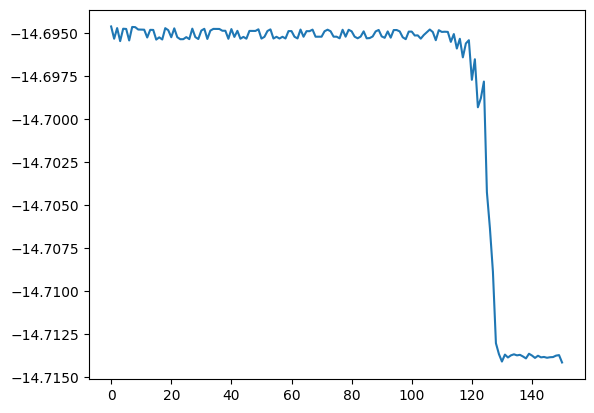

Schmidts (from only one paramset in each iteration):


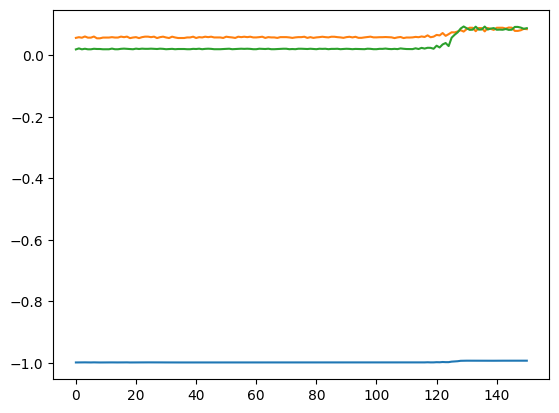

Parameters (from only one paramset in each iteration):


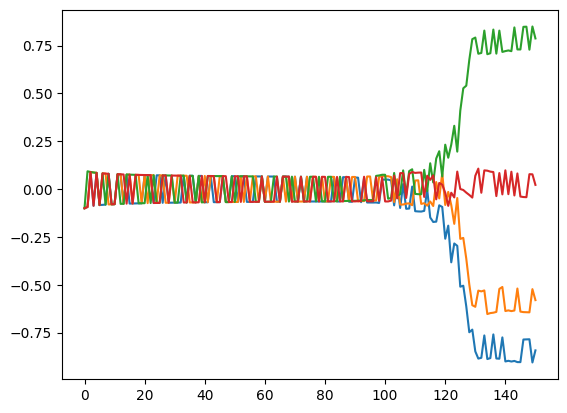

In [55]:
print("Energies (from only one paramset in each iteration):")
plt.plot([e[0] for e in res.get_energies_history()])
plt.show()
print("Schmidts (from only one paramset in each iteration):")
plt.plot([s[0] for s in res.get_schmidts_history()])
plt.show()
print("Parameters (from only one paramset in each iteration):")
plt.plot([p[0] for p in res.get_parameters_history()])
plt.show()

In [56]:
t2-t1

235.0734646320343